### libraries

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import kwant
from tqdm import tqdm
import matplotlib.gridspec as gridspec


/home/lizok/Desktop/projects/entropy/myenv2/lib/python3.11/site-packages/kwant-1.5.0a0.dev111+g7790469-py3.11-linux-x86_64.egg/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


### functions 

In [2]:
def calculate_dos(spectrum, energy, npoints, gamma):

    #  length = len(spectrum)
    ones = np.ones(len(spectrum))
    
    
    diff_sq = np.power(energy*ones - spectrum*ones, 2)
    gamma_sq = gamma * gamma * ones
    
    result = (gamma / np.pi) / (gamma_sq + diff_sq)
    
    dos = np.sum(result) / npoints
    
    return dos

# def calculate_dos(spectrum, energy, npoints, gamma):

#     length = len(spectrum)
#     result = np.empty(length)
#     for i in range(length):
#         result[i] =  (gamma/np.pi)*np.power(gamma*gamma+np.power(energy-spectrum[i], 2), -1)
        
#     return np.sum(result) / npoints

In [3]:
# def calculate_entropy(dos_data, npoints_energy, energy_cut_off, mu_set, T ):

#     entropy_results = np.empty(len(mu_set))
#     energy_vector = np.linspace(-energy_cut_off, energy_cut_off, npoints_energy)

#     for i in range(len(mu_set)):

#         mu = mu_set[i]
#         mu_vector = mu*np.ones(npoints_energy)

#         integral_numerator = np.sum(dos_data * (energy_vector - mu_vector) * np.power(np.cosh((energy_vector - mu_vector)/(2*T)),-2))

#         integral_denominator = np.sum(dos_data * np.power(np.cosh((energy_vector - mu_vector)/(2*T)),-2))

#         entropy_results = (1/T)*(integral_numerator/integral_denominator)

#     return entropy_results

import numpy as np

def calculate_entropy(dos_data, npoints_energy, energy_cut_off, mu_set, T):
    entropy_results = np.empty(len(mu_set))
    energy_vector = np.linspace(-energy_cut_off, energy_cut_off, npoints_energy)

    for i, mu in enumerate(mu_set):
        # Now directly use mu without creating a vector of ones
        integral_numerator = np.sum(dos_data * (energy_vector - mu) * np.power(np.cosh((energy_vector - mu)/(2*T)), -2))
        integral_denominator = np.sum(dos_data * np.power(np.cosh((energy_vector - mu)/(2*T)), -2))

        # Assign the computed value to the ith position of entropy_results
        entropy_results[i] = (1/T) * (integral_numerator / integral_denominator)

    return entropy_results


### ZGNR

In [ ]:
def make_zgnr_system(phi=0.005, E = 0.0):

    graphene = kwant.lattice.general([(1, 0), (np.sin(np.pi/6), np.cos(np.pi/6))],
                                     [(0, 0), (0, 1 / np.sqrt(3))],
                                     norbs=1)
    a, b = graphene.sublattices
    
    def rectangle(pos):
        length = 100
        x, y = pos
        return - length/2 < x < length/2 and -length/2 < y < length/2+0.3
    
    syst = kwant.Builder()
    
    
    def electric_f(site):
        x, y = site.pos
        return  - E * y

    
    syst[graphene.shape(rectangle, (0, 0))] = electric_f
    
    
    def hopping_magn(site1, site2):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        resphase = - np.exp((-0.5j * phi * (x1 - x2) * (y1 + y2)))
        return resphase
    
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping_magn
    
    sym = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    
    def lead_shape(pos):
        length = 100
        x, y = pos
        return -length/2 < y < length/2+0.3
    
    lead = kwant.Builder(sym)
    lead[graphene.shape(lead_shape, (0, 0))] = electric_f

    
    lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping_magn
    
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed());

    
    fsyst = syst.finalized()

    return fsyst

In [10]:
graphene = kwant.lattice.general([(1, 0), (np.sin(np.pi/6), np.cos(np.pi/6))],
                                 [(0, 0), (0, 1 / np.sqrt(3))],
                                 norbs=1)
a, b = graphene.sublattices

In [244]:
def rectangle(pos):
    length = 100
    x, y = pos
    return - length/2 < x < length/2 and -length/2 < y < length/2+0.3

syst = kwant.Builder()


syst[graphene.shape(rectangle, (0, 0))] = 0

In [245]:
phi = 0.005
aconst = 1

def hopping_magn(site1, site2):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    resphase = - np.exp((-0.5j * phi * (x1 - x2) * (y1 + y2)/aconst**2)* 2 * np.pi)
    return resphase

hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping_magn

In [246]:
sym = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))

def lead_shape(pos):
    length = 100
    x, y = pos
    return -length/2 < y < length/2+0.3

lead = kwant.Builder(sym)
lead[graphene.shape(lead_shape, (0, 0))] = 0
lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping_magn

syst.attach_lead(lead)
syst.attach_lead(lead.reversed());

#syst.eradicate_dangling()
#lead.eradicate_dangling()

fsyst = syst.finalized()

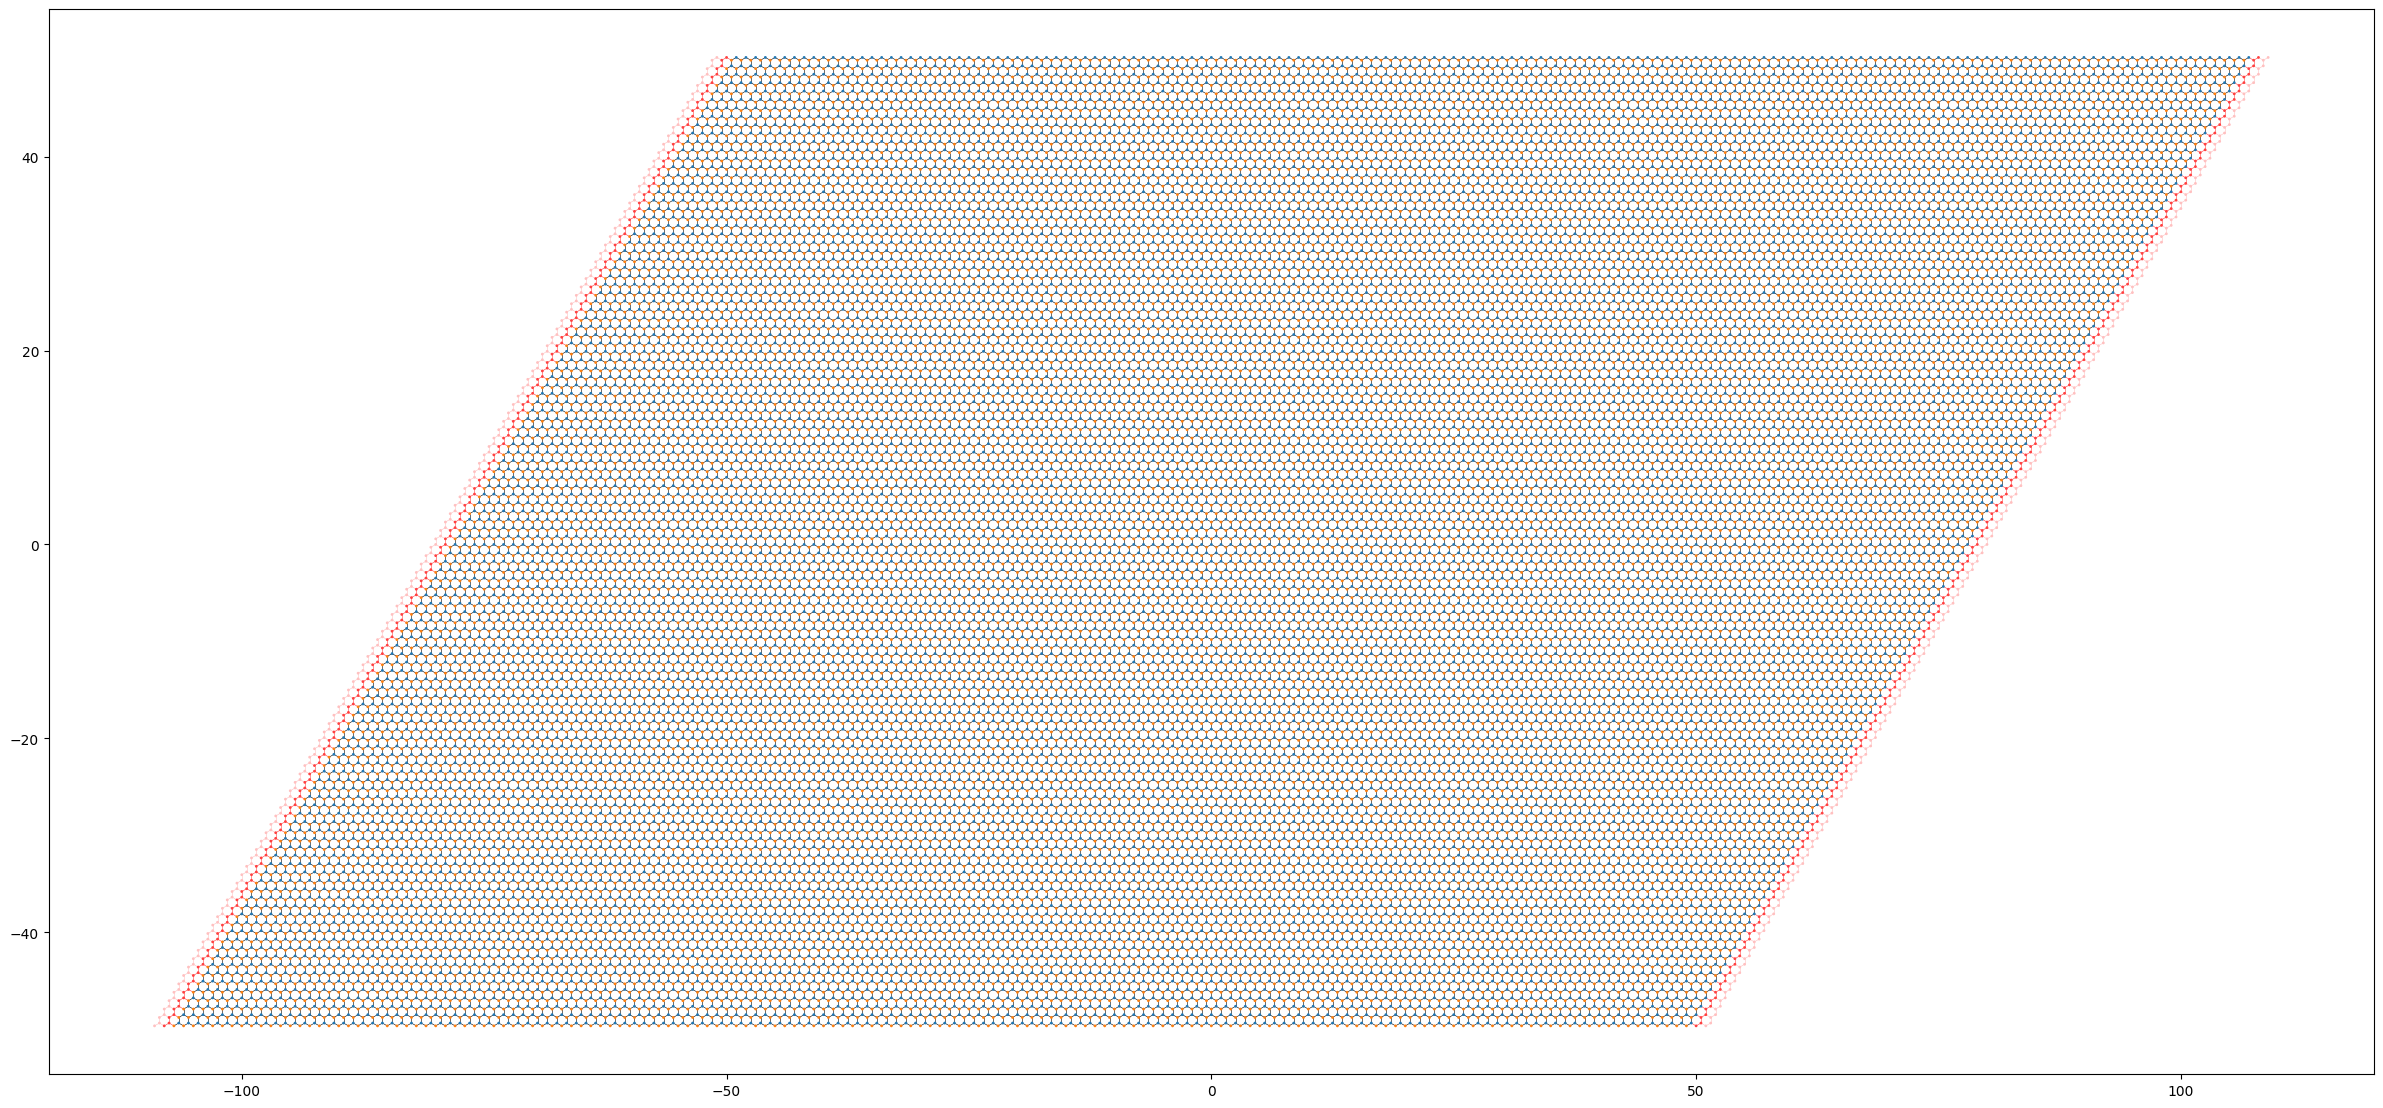

In [247]:
plt.rcParams["figure.figsize"] = (30,14)
kwant.plot(fsyst);

In [248]:
momenta = np.linspace(-np.pi, np.pi, 2001)
bands = kwant.physics.Bands(fsyst.leads[0])
energies = [bands(k) for k in momenta]

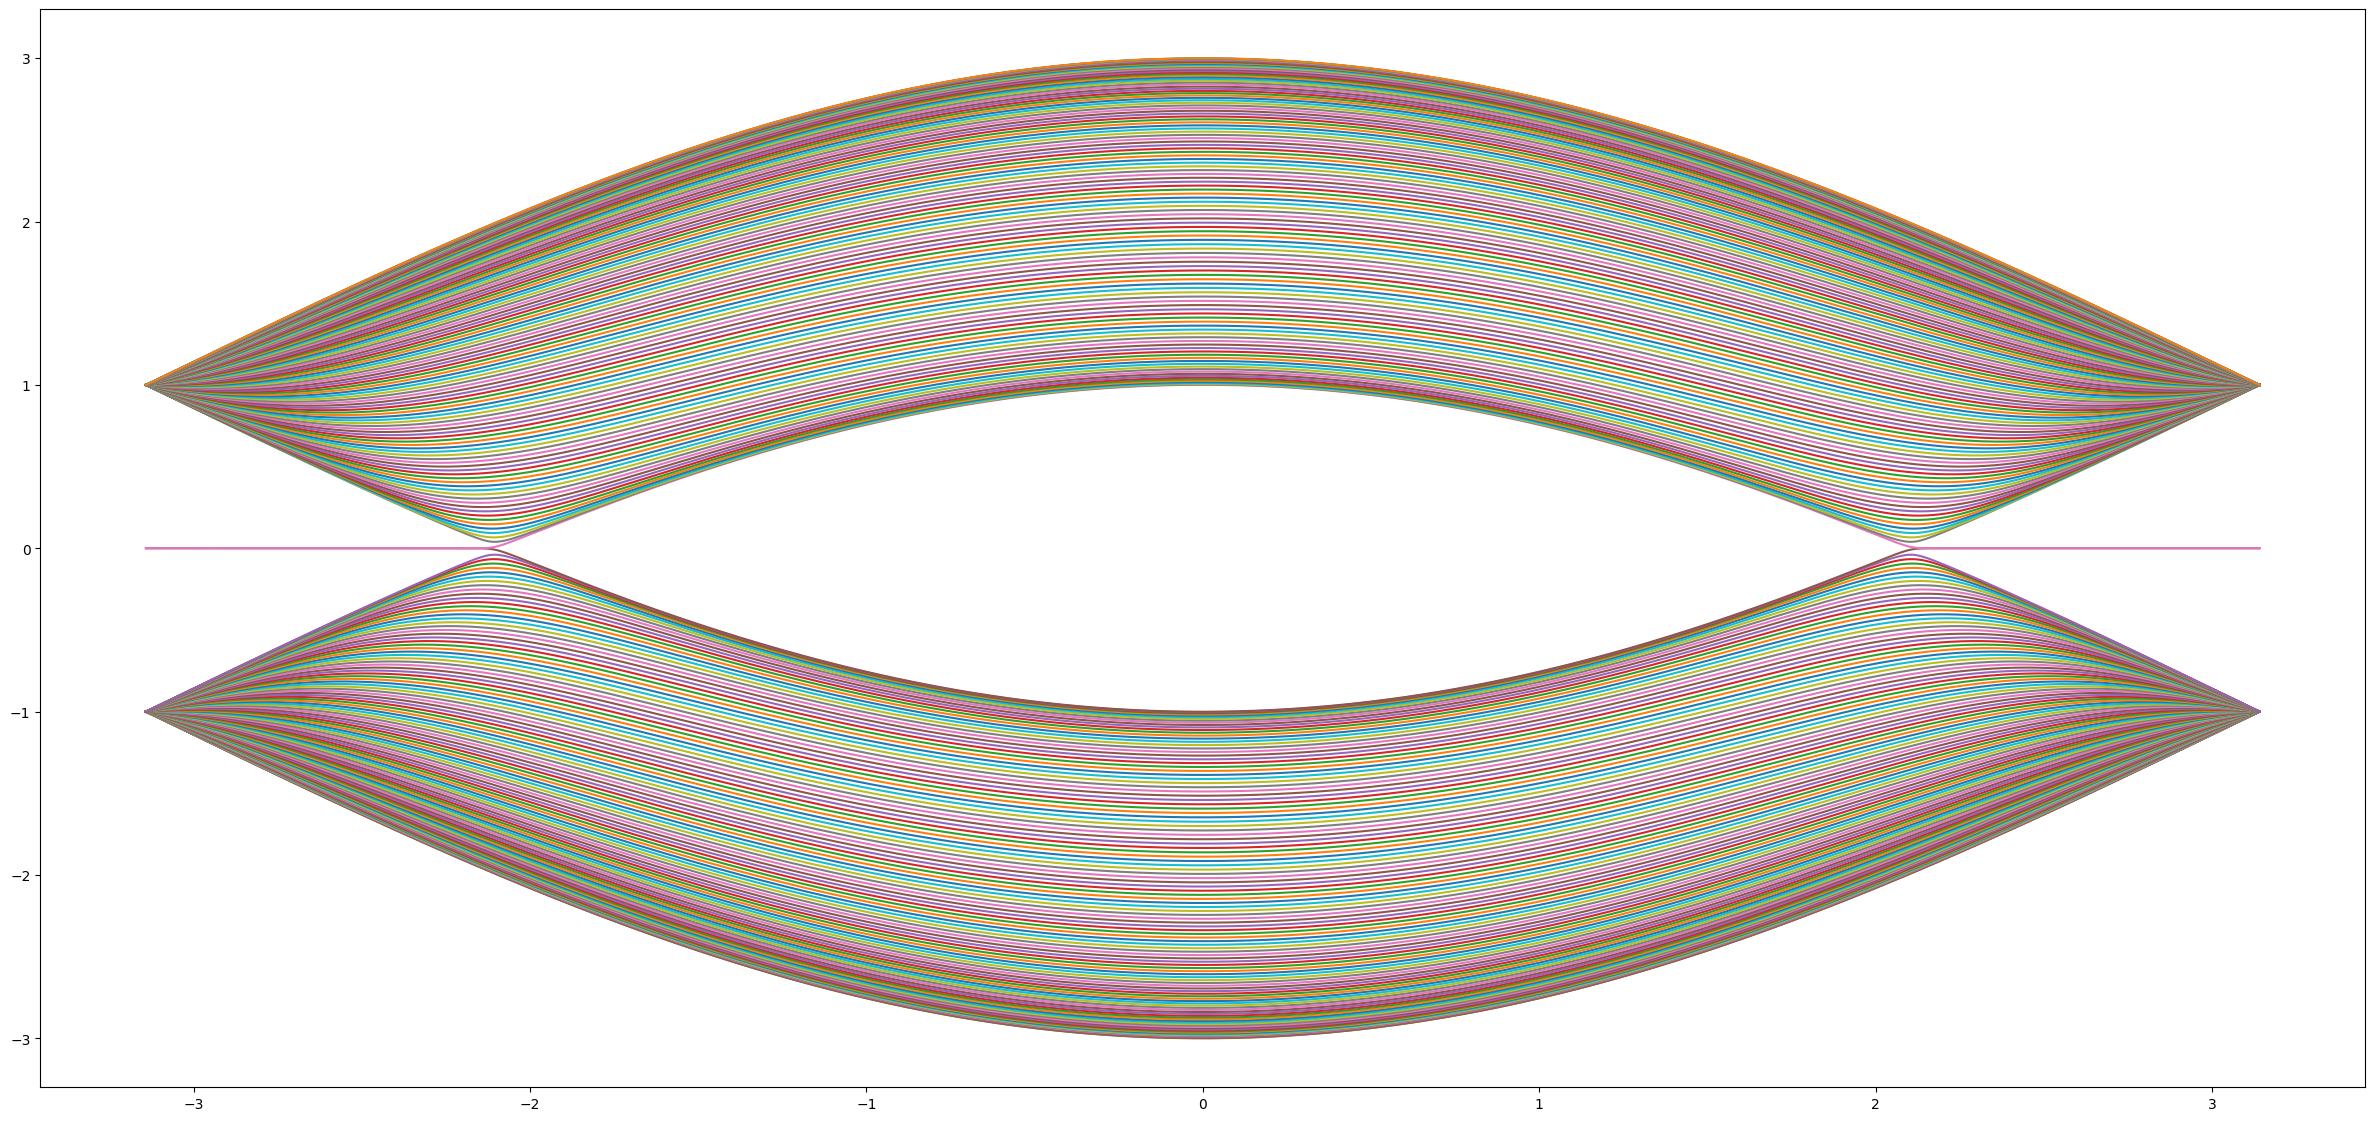

In [249]:
plt.plot(momenta,energies);

In [250]:
gamma = 0.01
npoints = 100_000
energyset = np.linspace(-4,4,500)

dos = [calculate_dos(spectrum=np.concatenate(energies), energy=ei, npoints=npoints, gamma=gamma)
                               for ei in energyset]
dos_kwant = [sum(kwant.ldos(fsyst,m)) for m in energyset]

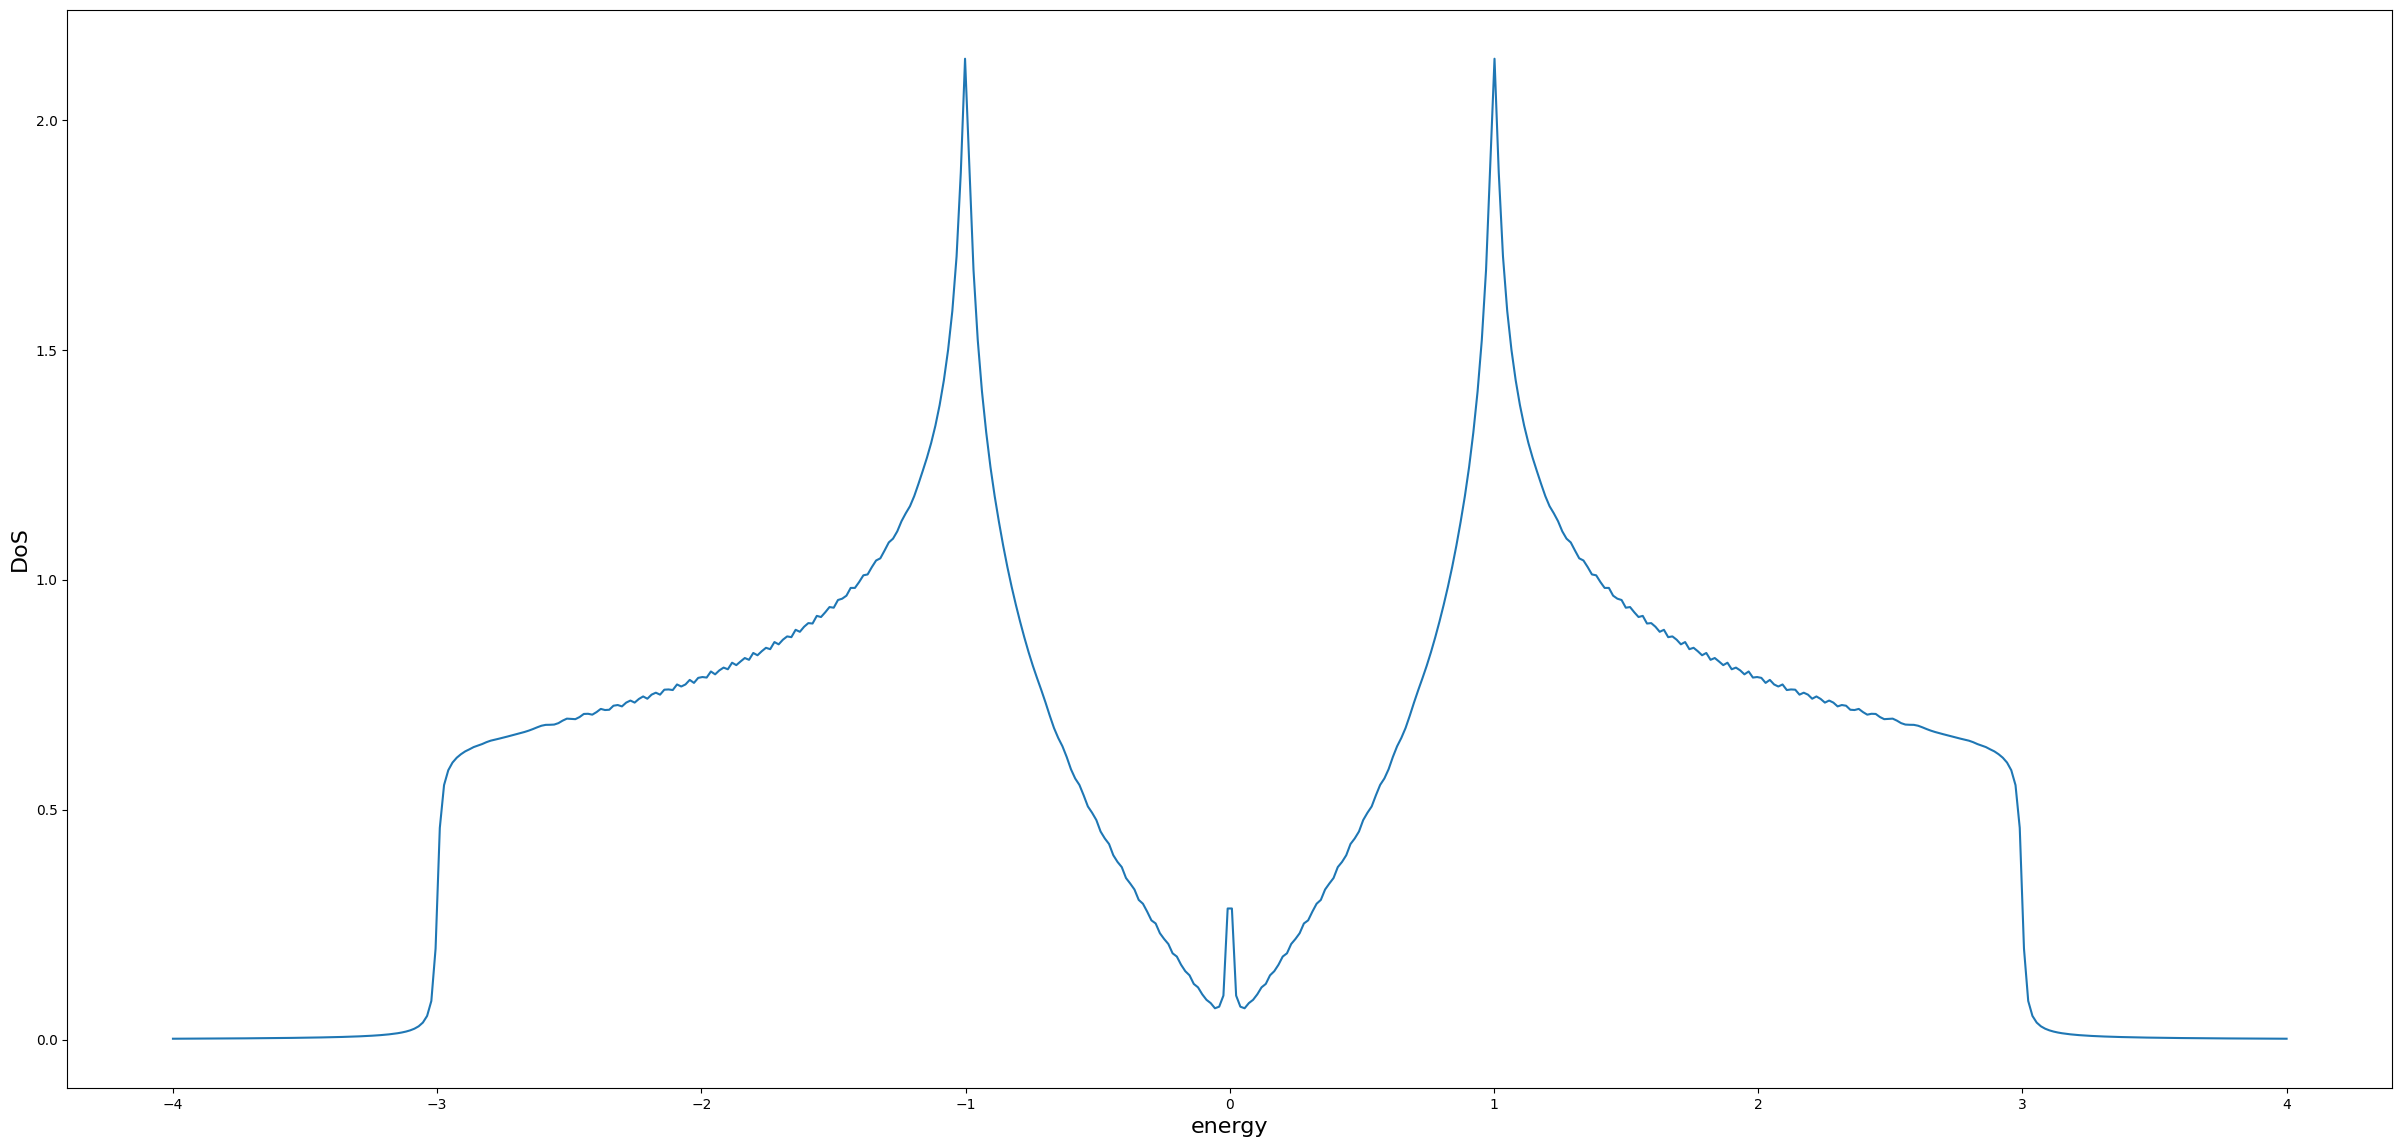

In [264]:
plt.plot(energyset,dos)
plt.xlabel('energy', size = 16)
plt.ylabel( 'DoS', size = 16)
plt.show()

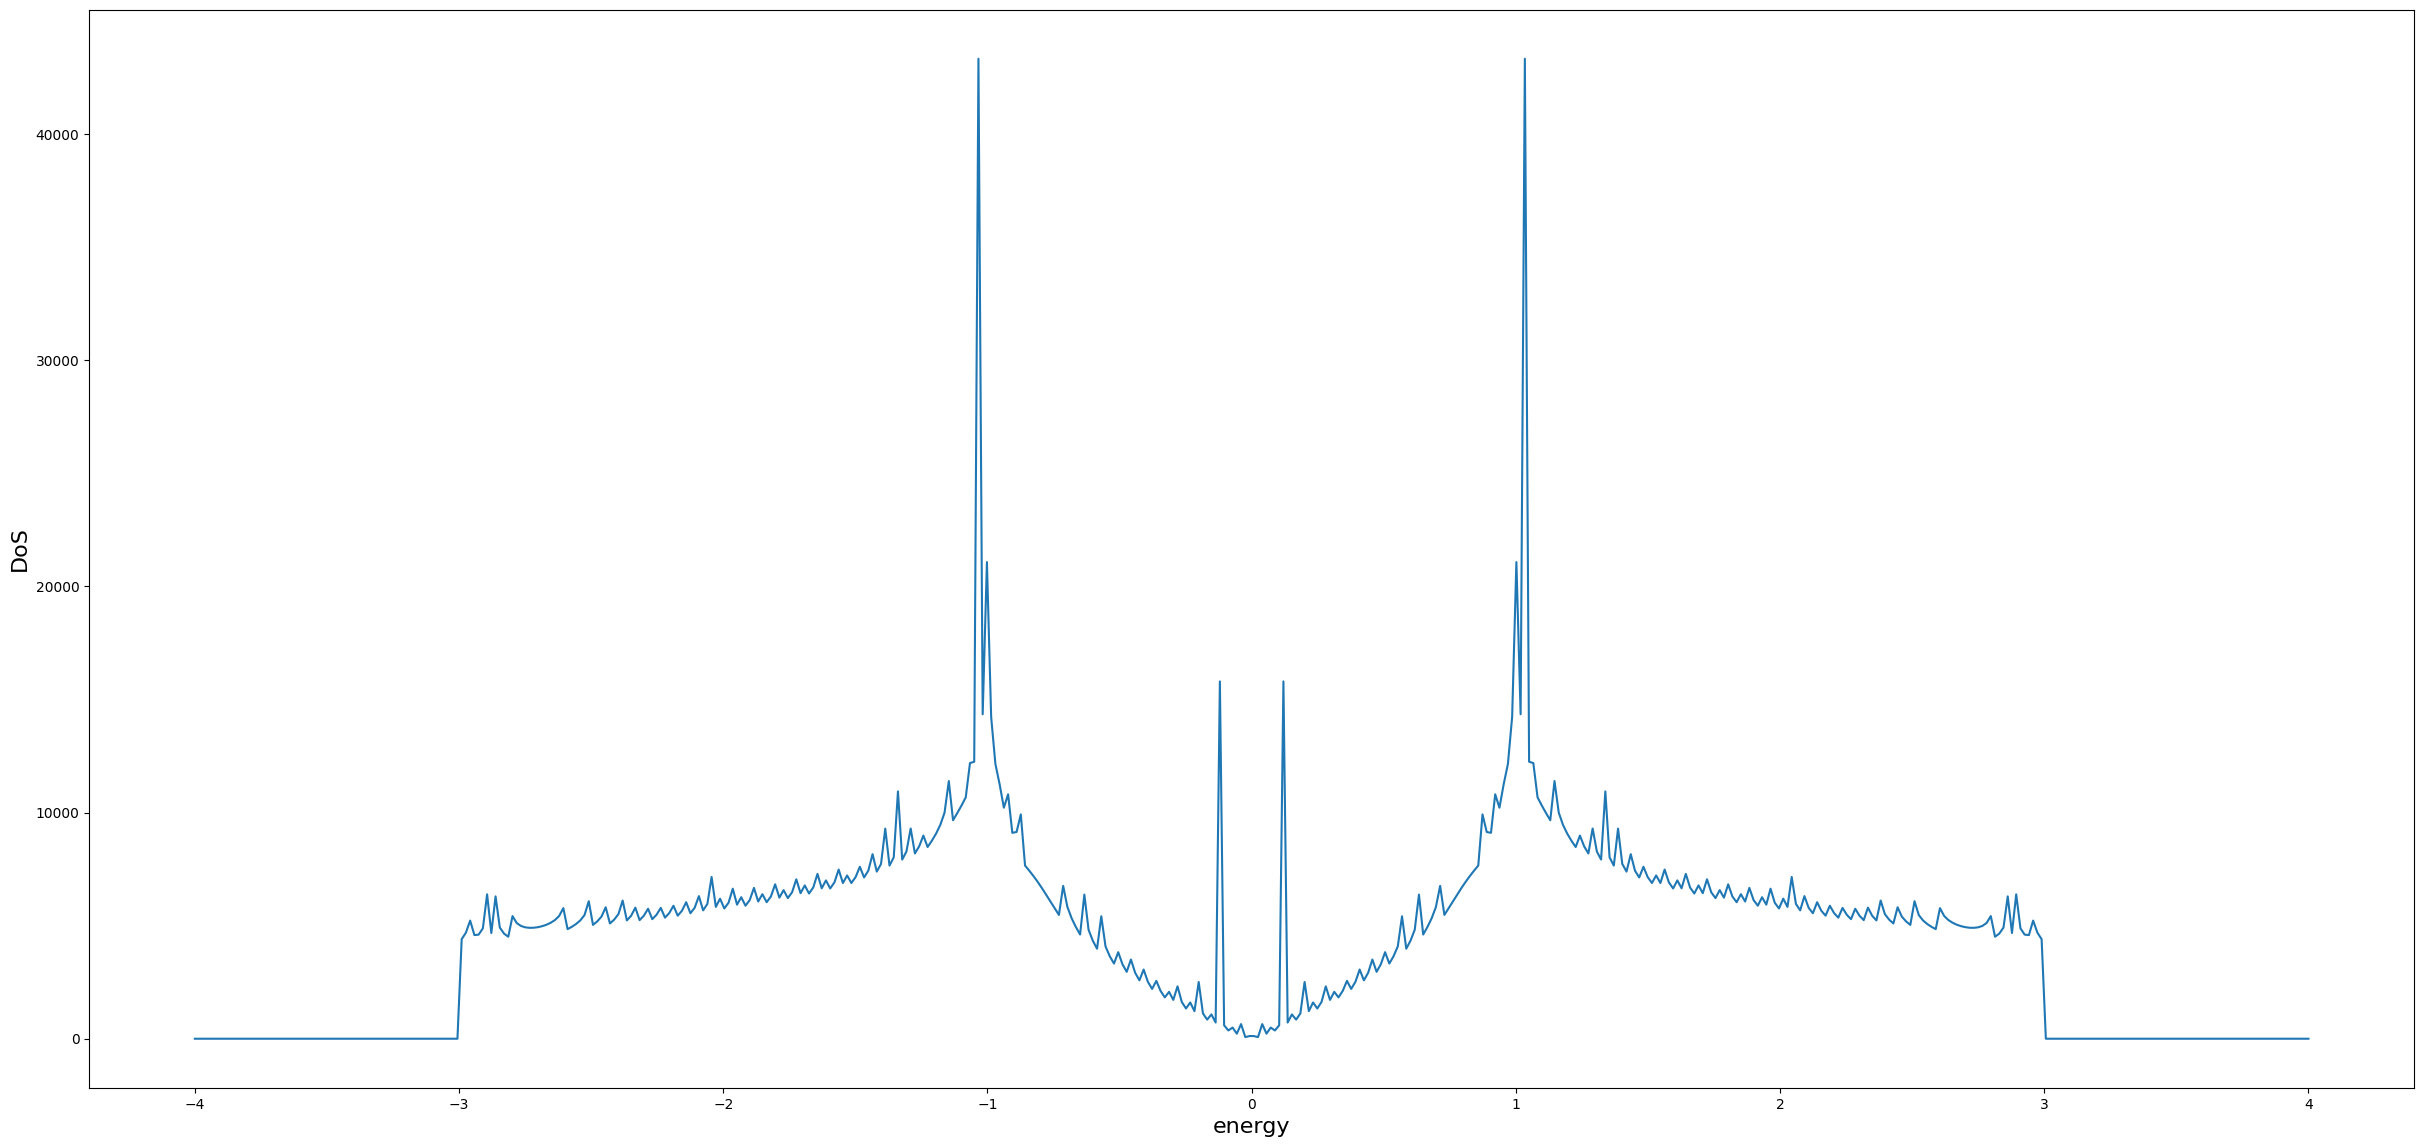

In [252]:
plt.plot(energyset,dos_kwant)
plt.xlabel('energy', size = 16)
plt.ylabel( 'DoS', size = 16)
plt.show()

In [263]:
np.savetxt('energies_ZGNR',energies)
np.savetxt('momentum', momenta)
np.savetxt('dos_sum_delta_funs_ZGNR', dos)
np.savetxt('dos_kwant_ZGNR', dos_kwant)
np.savetxt('energyset_for_dos', energyset)

### AGNR 

In [6]:
def make_system(E=0.0, phi = 0.0):

    graphene =  kwant.lattice.general([(np.sqrt(3)/2, 1/2), (0, 1)],
                             [(0, 0), (1 / (2*np.sqrt(3)),1/2)], norbs = 1)
    a, b = graphene.sublattices
        
    def rectangle(pos):
        length = 100
        x, y = pos
        return - length/2 < x < length/2 and -length/2 < y < length/2
    
    syst = kwant.Builder()
    
    def electric_f(site):
        x, y = site.pos
        return  - E * y
    
    
    
    syst[graphene.shape(rectangle, (0, 0))] = 0#electric_f
        
    def hopping_magn(site1, site2):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        resphase = - np.exp((-0.5j * phi * (x1 - x2) * (y1 + y2)))
        return resphase
    
    
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((1, 0), a, b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping_magn
    
    sym = kwant.TranslationalSymmetry(graphene.vec(( 2, -1)))
    
    def lead_shape(pos):
        length = 100
        x, y = pos
        return -length/2 < y < length/2
    
    lead = kwant.Builder(sym)
    lead[graphene.shape(lead_shape, (0, 0))] = electric_f
    lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] =  hopping_magn
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed());
    
    fsyst = syst.finalized()

    return fsyst

In [5]:
graphene =  kwant.lattice.general([(np.sqrt(3)/2, 1/2), (0, 1)],
                         [(0, 0), (1 / (2*np.sqrt(3)),1/2)], norbs = 1)
a, b = graphene.sublattices

In [5]:
E = 0.000

def rectangle(pos):
    length = 100
    x, y = pos
    return - length/2 < x < length/2 and -length/2 < y < length/2

syst = kwant.Builder()

def electric_f(site):
    x, y = site.pos
    return  - E * y



syst[graphene.shape(rectangle, (0, 0))] = electric_f

In [6]:
phi = 0.00
aconst = 1

def hopping_magn(site1, site2):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    resphase = - np.exp((-0.5j * phi * (x1 - x2) * (y1 + y2)/aconst**2))
    return resphase


hoppings = (((0, 0), a, b), ((0, 1), a, b), ((1, 0), a, b))
syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping_magn

In [7]:
sym = kwant.TranslationalSymmetry(graphene.vec(( 2, -1)))

def lead_shape(pos):
    length = 100
    x, y = pos
    return -length/2 < y < length/2

lead = kwant.Builder(sym)
lead[graphene.shape(lead_shape, (0, 0))] = electric_f
lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] =  hopping_magn
syst.attach_lead(lead)
syst.attach_lead(lead.reversed());

/home/lizok/Desktop/projects/entropy/myenv2/lib/python3.11/site-packages/kwant-1.5.0a0.dev111+g7790469-py3.11-linux-x86_64.egg/kwant/_plotter.py:77: RuntimeWarning: plotly is not available, if other engines are unavailable, only iterator-providing functions will work
  warnings.warn("plotly is not available, if other engines are unavailable,"
/home/lizok/Desktop/projects/entropy/myenv2/lib/python3.11/site-packages/kwant-1.5.0a0.dev111+g7790469-py3.11-linux-x86_64.egg/kwant/plotter.py:893: RuntimeWarning: Kwant's plotting functions have
the side effect of selecting the matplotlib backend. To avoid this warning,
import matplotlib.pyplot, matplotlib.backends or call matplotlib.use().
  fig = _plot_matplotlib(sys, num_lead_cells, unit,


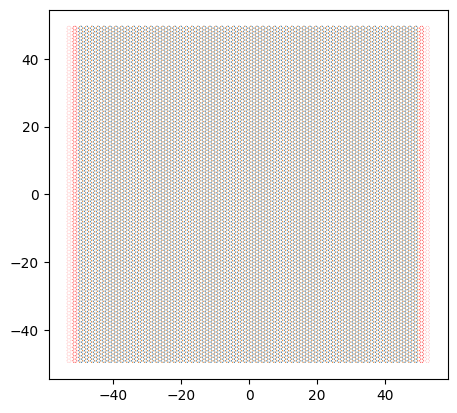

In [8]:
kwant.plot(syst);

In [9]:
# lead.eradicate_dangling()
# syst.eradicate_dangling()


In [10]:
fsyst = syst.finalized()

In [11]:
%%time



momenta = np.linspace(-np.pi, np.pi, 2001)
bands = kwant.physics.Bands(fsyst.leads[0])
energies = [bands(k) for k in momenta]

CPU times: user 2min 59s, sys: 9min 11s, total: 12min 11s
Wall time: 46.1 s


In [12]:
np.array(energies).shape

(2001, 398)

In [16]:
len(e_fields_array)

10

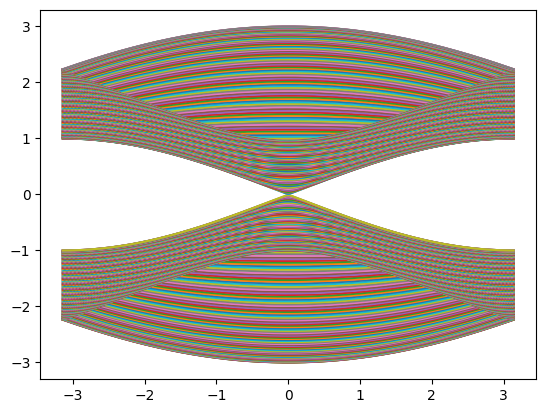

In [82]:
plt.plot(momenta,energies);

In [17]:
%%time

gamma = 0.001
npoints = 10_000
energyset = np.linspace(-4,4,5000)

dos_wo_fields = [calculate_dos(spectrum=np.concatenate(energies), energy=ei, npoints=npoints, gamma=gamma)
                               for ei in energyset]

CPU times: user 58.4 s, sys: 24 s, total: 1min 22s
Wall time: 1min 22s


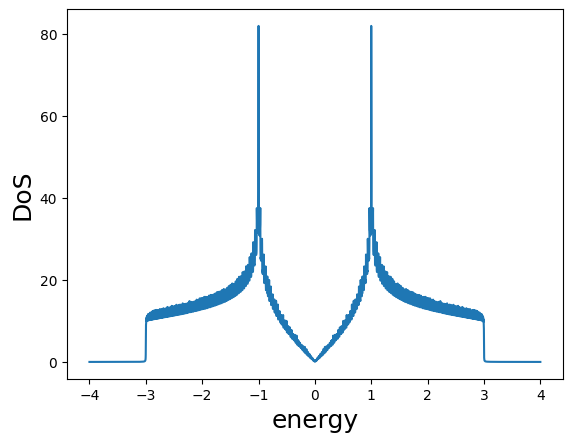

In [18]:
plt.plot(energyset,dos_wo_fields)
plt.xlabel('energy', size = 18)
plt.ylabel( 'DoS', size = 18)
plt.show()

In [66]:
#array_of_T = [0.01,0.1]
cut_off = 5.0
npoints_energy = 5000
T = 0.01
entropy_wo_fields = calculate_entropy(dos_data=dos_wo_fields, npoints_energy=npoints_energy, energy_cut_off=cut_off, mu_set=energyset, T=T)

In [67]:
entropy_wo_fields

array([ 0.13088597,  0.13174106,  0.132608  , ..., -0.132608  ,
       -0.13174106, -0.13088597])

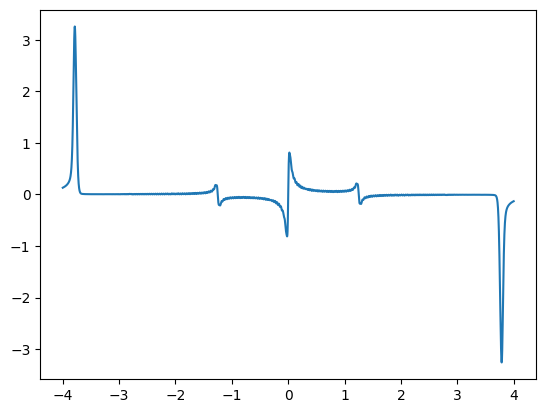

In [68]:
plt.plot(energyset,entropy_wo_fields)
plt.show()

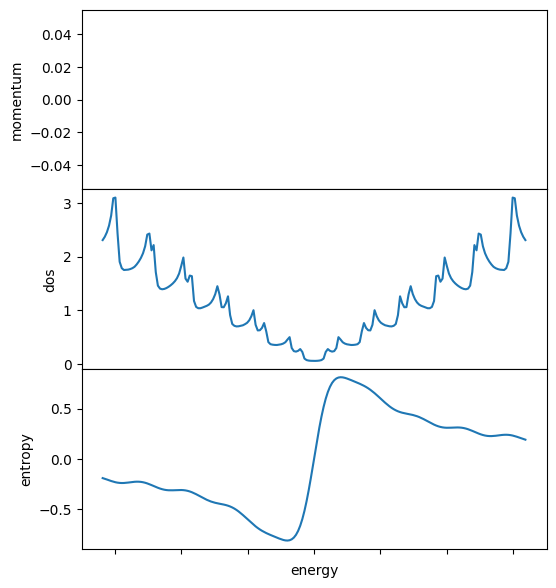

In [69]:
fig = plt.figure(figsize=(6, 7))

gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,1])

gs.update(hspace=0.0) 

ax0 = plt.subplot(gs[0])
ax0.plot( energies[2400:2600], momenta[2400:2600])
ax0.set_ylabel('momentum')
ax0.set_xticklabels([])

ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.plot(energyset[2400:2600], dos_wo_fields[2400:2600])
ax1.set_ylabel('dos')
ax1.set_xticklabels([])

ax2 = plt.subplot(gs[2], sharex=ax1)
ax2.plot(energyset[2400:2600], entropy_wo_fields[2400:2600])
ax2.set_ylabel('entropy')

plt.xlabel('energy')
plt.show()

In [89]:
np.savetxt('energyset_wo_fields', energyset)
np.savetxt('dos_wo_fields', dos_wo_fields)
np.savetxt('entropy_wo_fields', entropy_wo_fields)

In [92]:
len(energyset)

5000

In [62]:
import numpy as np

# Assuming peierls_phase function is defined as before, and 'B' is your magnetic field strength

# Example hexagonal cell corner coordinates (schematic, adjust according to your lattice constants)
# This is an oversimplified representation for illustration
hexagon_corners = [(1, 0), (0.5, np.sqrt(3)/2), (-0.5, np.sqrt(3)/2),
                   (-1, 0), (-0.5, -np.sqrt(3)/2), (0.5, -np.sqrt(3)/2)]

# To calculate the phases, we need the sites corresponding to these corners.
# In a real scenario, you would use your graphene lattice object to get these.
# Here, we directly use the positions for demonstration.

# Calculate the total phase around the hexagon
total_phase = 0
for i in range(len(hexagon_corners)):
    site1_pos = hexagon_corners[i]
    site2_pos = hexagon_corners[(i+1) % len(hexagon_corners)]  # Wrap around to the first site
    
    # Convert positions to sites in your actual code
    site1 = site1_pos  # In real code: graphene.sublattice(site1_pos), or similar
    site2 = site2_pos  # Ditto
    
    # Add the phase for this hopping
    # In real code, use actual site objects with peierls_phase(site1, site2, B)
    total_phase += np.log(hopping_magn(site1, site2))

# The flux through the hexagon in units of the flux quantum Phi_0
flux_through_hexagon = total_phase.imag / (2 * np.pi)

print(f"Total magnetic flux through the hexagonal cell (in units of flux quantum): {flux_through_hexagon}")


AttributeError: 'tuple' object has no attribute 'pos'

### AGNR + ZGNR in one function

In [5]:
def make_graphene(t = -1, W=200,L=10,A = [0,2 * np.pi], C='AGNR',B = [-1,1,-1,1], phi=0.,E=0.,EF=False,MF = False,PS = False, bands = True, wf = False, ldos = False, cond = False, DoS = False):

    t_1, t_2 = t, t
    
    aconst = 1
    electrical_field = EF
    magnetic_field = MF
    plot_system = PS
    width = W
    length = L
    cutting = C
    density_of_states = DoS
    xmin, xmax, ymin, ymax = B # borders
   # v_drift = 2 * np.pi * E / phi 
    v_fermi = 3/2  +0.000001
    mom_min, mom_max = A

    if cutting == 'AGNR':
        lattice =  kwant.lattice.general([(np.sqrt(3)/2, 1/2), (0, 1)],
                                 [(0, 0), (1 / (2*np.sqrt(3)),1/2)], norbs = 1)
    if cutting == 'ZGNR':
        lattice =  kwant.lattice.honeycomb(norbs = 1)

    a, b = lattice.sublattices
    def family_colors(site):
        return 0 if site.family == a else 1

    def square(pos):
        x, y = pos
        if cutting == 'ZGNR':
            return 0 <= x < length and - width / 2 + 0.5 <= y < width / 2 + 0.5 
        if cutting == 'AGNR':
            return  0 <= x < length and -width / 2 <= y < width / 2
        
        
    if magnetic_field == True:
        
        def t1(site1, site2, phi):
            x1, y1 = site1.pos
            x2, y2 = site2.pos
            resphase = t_1 * np.exp((-0.5j * phi * (x1 - x2) * (y1 + y2)/aconst**2)* 2 * np.pi)
            return resphase

        def t2(site1, site2, phi):
            x1, y1 = site1.pos
            x2, y2 = site2.pos
            resphase = t_2 * np.exp((-0.5j * phi * (x1 - x2) * (y1 + y2)/aconst**2)* 2 * np.pi)
            return resphase
    if magnetic_field == False:
        t1,t2 = t_1, t_2


    def electric_f(site):
        x, y = site.pos
        return  - E * y


    system = kwant.Builder()

    if electrical_field == True:
        system[lattice.shape(square, (0, 0))] = electric_f
    if electrical_field == False:
        system[lattice.shape(square, (0, 0))] = 0


    if cutting == 'ZGNR':
        system[kwant.builder.HoppingKind((0, 0), a, b)] = t2 # vertical hopping
        system[kwant.builder.HoppingKind((0, 1), a, b)] = t1 # not main diagonal
        system[kwant.builder.HoppingKind((-1, 1), a, b)] = t1 # main diagonal
    if cutting == 'AGNR':
        system[kwant.builder.HoppingKind((0, 0), a, b)] = t1 # not main diagonal
        system[kwant.builder.HoppingKind((0, 1), a, b)] = t1 #  main diagonal
        system[kwant.builder.HoppingKind((1, 0), a, b)] = t2 # horisontal



    def lead0_shape(pos):
        x, y = pos
        if cutting == 'ZGNR':
            return -width /2 + 0.5 <= y < width/2 + 0.5 
        if cutting == 'AGNR':
            return -width /2 <= y < width/2

    if cutting == 'AGNR':
        sym0 = kwant.TranslationalSymmetry(lattice.vec(( 2, -1)))
        lead0 = kwant.Builder(sym0)
    if cutting == 'ZGNR':
        sym0 = kwant.TranslationalSymmetry(lattice.vec((- 1, 0)))
        lead0 = kwant.Builder(sym0)
      
    if electrical_field == True:
        lead0[lattice.shape(lead0_shape, (0, 0))] = electric_f
    if electrical_field == False:
        lead0[lattice.shape(lead0_shape, (0, 0))] = 0
        
    
    if cutting == 'AGNR':
        lead0[kwant.builder.HoppingKind((0, 0), a, b)] = t1 # vertical hopping
        lead0[kwant.builder.HoppingKind((0, 1), a, b)] = t1 # not main diagonal
        lead0[kwant.builder.HoppingKind((1, 0), a, b)] = t2 # main diagonal
    if cutting == 'ZGNR':
        lead0[kwant.builder.HoppingKind((0, 0), a, b)] = t2 # vertical hopping
        lead0[kwant.builder.HoppingKind((0, 1), a, b)] = t1 # not main diagonal
        lead0[kwant.builder.HoppingKind((-1, 1), a, b)] = t1 # main diagonal

    
    
    lead0.eradicate_dangling()
    system.eradicate_dangling()
    system.attach_lead(lead0)
    system.attach_lead(lead0.reversed())


    
  
    if plot_system == True:
        plt.rcParams['figure.figsize'] = (10, 4)
        kwant.plot(system, site_color=family_colors, site_lw=0.1,
                   lead_site_lw=0, colorbar=False, show = False)
        plt.title('system with leads', size = 20)
        plt.show()  
    
    
    fsystem, flead0 = system.finalized(), lead0.finalized()
    
    
            
    if bands == True:
        
        momentum = np.linspace(mom_min, mom_max, 200)      
        bands = kwant.physics.Bands(flead0, params = {'phi': phi})
        energies = [bands(k) for k in momentum]
        
        plt.plot(momentum, energies)
            
        plt.xlabel("momentum", size = 16)
        plt.ylabel("energy [t]", size = 16)
        if B != [-1,1,-1,1]:
            plt.xlim(xmin,xmax)
            plt.ylim(ymin,ymax)
        # pdf.savefig()
        plt.show()
        
        # for future calculations
        energies = np.array(energies)[np.array(energies)>=0]
        energy = np.min(energies)

    

    
    
    if wf == True:
        psi = kwant.solvers.default.wave_function(fsystem, energy=energy, params = {'phi': phi})
        psi_1 = psi(0)[0]
        amplitude=[abs(h) for h in psi_1]
        phases = [phase(h) for h in psi_1]
        amplitude_norm = [g / 2 for g in amplitude] #np.linalg.norm(amplitude)
        kwant.plot(system,site_size=amplitude_norm,site_color=phases, cmap='cool', show = False)
        plt.title('wave function', size = 20)
        plt.show()
    
    if ldos == True:
        density = kwant.ldos(fsystem,params={'phi':phi}, energy = energy)
        ldos_norm = [j *2  for j in density] #np.linalg.norm(amplitude)
        kwant.plot(system,site_size=ldos_norm,site_color='blue' , show = False)
        plt.title('local density of states', size = 20)
        plt.show()
        
        
    energyset = np.linspace(-3,3,1001)

    if cond == True:
        conductivity = [kwant.smatrix(fsystem,o,params = {'phi': phi}).transmission(1,0) for o in energies]
        plt.plot(energies, conductivity, label = 'conductivity')
        plt.xlabel('energy', size = 16)
        plt.ylabel( 'conductivity', size = 16)
        plt.show()
    
    if density_of_states == True:
        dos = [sum(kwant.ldos(fsystem,m,params = {'phi': phi})) for m in energies]
        plt.plot(energies,dos)
        plt.xlabel('energy', size = 16)
        plt.ylabel( 'DoS', size = 16)
        plt.show()
    plt.show()
    
    return energies

/home/lizok/Desktop/projects/entropy/myenv2/lib/python3.11/site-packages/kwant-1.5.0a0.dev111+g7790469-py3.11-linux-x86_64.egg/kwant/_plotter.py:77: RuntimeWarning: plotly is not available, if other engines are unavailable, only iterator-providing functions will work
  warnings.warn("plotly is not available, if other engines are unavailable,"
/home/lizok/Desktop/projects/entropy/myenv2/lib/python3.11/site-packages/kwant-1.5.0a0.dev111+g7790469-py3.11-linux-x86_64.egg/kwant/plotter.py:893: RuntimeWarning: Kwant's plotting functions have
the side effect of selecting the matplotlib backend. To avoid this warning,
import matplotlib.pyplot, matplotlib.backends or call matplotlib.use().
  fig = _plot_matplotlib(sys, num_lead_cells, unit,


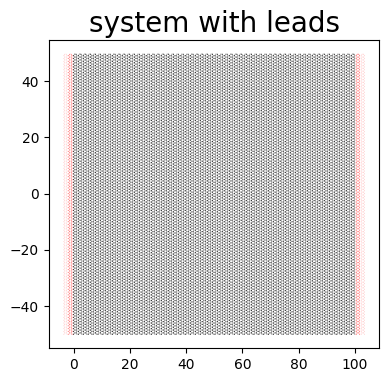

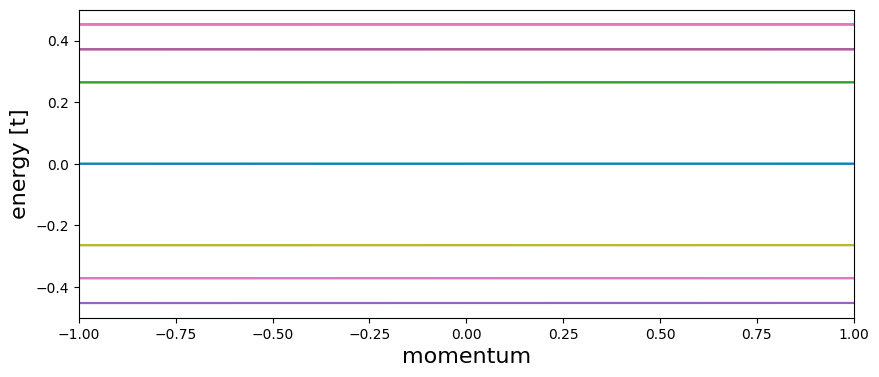

KeyboardInterrupt: 

In [6]:
energies_B_005_E_002_AGNR = make_graphene(W = 100,L=100,A = [-np.pi, np.pi],C = 'AGNR',B = [-1,1,-0.5,0.5], PS = True, bands = True, EF=True, MF = True, phi=0.0075, E = 0.000005,DoS=True)
#energies_B_005_E_005_AGNR = make_graphene(W = 200,A = [-np.pi, np.pi],C = 'AGNR', PS = True, bands = True, EF=True, MF = True, phi=0.005, E = 0.005)
##energies_B_005_E_006_AGNR = make_graphene(W = 200,A = [-np.pi, np.pi],C = 'AGNR', PS = True, bands = True, EF=True, MF = True, phi=0.005, E = 0.006)
#energies_B_005_E_007_AGNR = make_graphene(W = 200,A = [-np.pi, np.pi],C = 'AGNR', PS = True, bands = True, EF=True, MF = True, phi=0.005, E = 0.007)
#energies_B_005_E_0075_AGNR = make_graphene(W = 200,A = [-np.pi, np.pi],C = 'AGNR', PS = True, bands = True, EF=True, MF = True, phi=0.005, E = 0.0075 )

In [ ]:
energies_B_005_E_002_AGNR

energies_B_005_E_002_AGNR
energies_B_005_E_002_AGNR
energies_B_005_E_002_AGNR




In [349]:
%%time

gamma = 0.01
npoints = 100_000
energyset = np.linspace(-4,4,1001)

dos_B_005_E_002_AGNR = [calculate_dos(spectrum=np.concatenate(energies_B_005_E_002_AGNR), energy=ei, npoints=npoints, gamma=gamma)
                               for ei in energyset]

# dos_B_005_E_005_AGNR = [calculate_dos(spectrum=np.concatenate(energies_B_005_E_005_AGNR), energy=ei, npoints=npoints, gamma=gamma)
#                                for ei in energyset]

# dos_B_005_E_006_AGNR = [calculate_dos(spectrum=np.concatenate(energies_B_005_E_006_AGNR), energy=ei, npoints=npoints, gamma=gamma)
#                                for ei in energyset]

# dos_B_005_E_007_AGNR = [calculate_dos(spectrum=np.concatenate(energies_B_005_E_007_AGNR), energy=ei, npoints=npoints, gamma=gamma)
#                                for ei in energyset]

# dos_B_005_E_0075_AGNR = [calculate_dos(spectrum=np.concatenate(energies_B_005_E_0075_AGNR), energy=ei, npoints=npoints, gamma=gamma)
#                                for ei in energyset]

CPU times: user 2min 29s, sys: 33.2 ms, total: 2min 29s
Wall time: 2min 29s


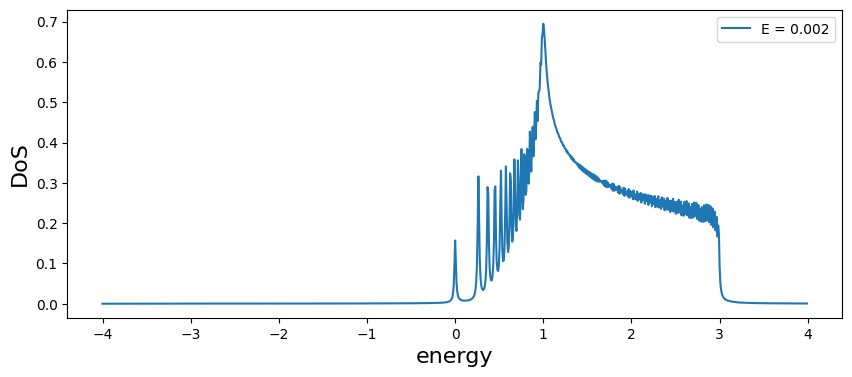

In [350]:
plt.plot(energyset[:1000],dos_B_005_E_002_AGNR[:1000], label = 'E = 0.002')
#plt.plot(energyset,dos_B_005_E_005_AGNR, label = 'E = 0.005')
#plt.plot(energyset,dos_B_005_E_006_AGNR, label = 'E = 0.006')
#plt.plot(energyset,dos_B_005_E_007_AGNR, label = 'E = 0.007')
#plt.plot(energyset,dos_B_005_E_0075_AGNR, label = 'E = 0.0075')
plt.xlabel('energy', size = 16)
plt.ylabel( 'DoS', size = 16)
plt.legend()
plt.show()

In [344]:
# np.savetxt('dos_B_005_E_002_AGNR', dos_B_005_E_002_AGNR)
# np.savetxt('dos_B_005_E_005_AGNR', dos_B_005_E_005_AGNR)
# np.savetxt('dos_B_005_E_006_AGNR', dos_B_005_E_006_AGNR)
# np.savetxt('dos_B_005_E_007_AGNR', dos_B_005_E_007_AGNR)
# np.savetxt('dos_B_005_E_0075_AGNR', dos_B_005_E_0075_AGNR)

In [312]:
dos_B_005_E_002_AGNR

[0.0008732914949887386,
 0.0008787652343619897,
 0.0008842968891620719,
 0.0008898876297906584,
 0.0008955386821990091,
 0.000901251332876414,
 0.0009070269344601421,
 0.0009128669120616678,
 0.0009187727704209049,
 0.0009247461020206455,
 0.0009307885963181729,
 0.0009369020502811558,
 0.0009430883804517244,
 0.0009493496368077782,
 0.0009556880187462438,
 0.0009621058935819435,
 0.0009686058180416222,
 0.0009751905633402323,
 0.000981863144562028,
 0.0009886268552406843,
 0.0009954853082515904,
 0.0010024424844105903,
 0.0010095027905369979,
 0.0010166711292125007,
 0.0010239529830899123,
 0.0010313545174303125,
 0.0010388827056495911,
 0.0010465454841438293,
 0.0010543519446934084,
 0.0010623125755466084,
 0.001070439566193556,
 0.0010787471963708353,
 0.0010872523377660828,
 0.0010959751084349046,
 0.0011049397370247712,
 0.0011141757196380107,
 0.0011237193917138064,
 0.0011336160994078945,
 0.0011439232548229317,
 0.0011547147244142617,
 0.001166087280659558,
 0.00117817034128428

### new attempt

In [ ]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
from math import pi, sqrt, tanh

# Constants
a = 1.42e-9  # [m] lattice constant of graphene
t = 2.7  # [eV] nearest neighbor hopping energy in graphene

B_field = 0.005    # Tesla
phi = B_field * 3 * sqrt(3) / 2 * a**2  # Flux through a hexagon

E_field = 0.0002   # V/m
electric_potential = E_field * a  # Potential difference across one lattice constant

sin_30, cos_30 = (1 / 2, sqrt(3) / 2)
graphene = kwant.lattice.general([(a, 0), (a * cos_30, a * sin_30)],
                                 [(0, 0), (0, a / sqrt(3))],
                                 norbs=1)
a, b = graphene.sublattices

def magnetic_field(site1, site2):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return np.exp(-1j * 2 * pi * phi * (x1 - x2) * (y1 + y2) / (3 * sqrt(3) * a**2))

def electric_field(site):
    (x, y) = site.pos
    return 4 * t - electric_potential * y / a 

sys = kwant.Builder()
sys[graphene.shape(lambda pos: True, (0, 0))] = electric_field
sys[graphene.neighbors()] = -t * magnetic_field

finalized_sys = sys.finalized()

energies = np.linspace(-10 * t, 10 * t, 400)
dos = kwant.dos(finalized_sys, energies)

plt.figure()
plt.plot(energies, dos)
plt.xlabel('Energy (eV)')
plt.ylabel('DOS')
plt.title('Density of States for Graphene with Magnetic and Electric Fields')
plt.grid(True)
plt.show()


/home/lizok/Desktop/projects/entropy/myenv2/lib/python3.11/site-packages/kwant-1.5.0a0.dev111+g7790469-py3.11-linux-x86_64.egg/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


### all info in big arrays 

In [43]:
def make_system(E=0.0, phi = 0.0):

    size = 100

    graphene =  kwant.lattice.general([(np.sqrt(3)/2, 1/2), (0, 1)],
                             [(0, 0), (1 / (2*np.sqrt(3)),1/2)], norbs = 1)
    a, b = graphene.sublattices
        
    def rectangle(pos):
        length = size
        x, y = pos
        return - length/2 < x < length/2 and -length/2 < y < length/2
    
    syst = kwant.Builder()
    
    def electric_f(site):
        x, y = site.pos
        return  - E * y
    
    
    
    syst[graphene.shape(rectangle, (0, 0))] = 0#electric_f
        
    def hopping_magn(site1, site2):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        resphase = - np.exp((-0.25j * phi * (x1 - x2) * (y1 + y2)))
        return resphase
    
    
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((1, 0), a, b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping_magn
    
    sym = kwant.TranslationalSymmetry(graphene.vec(( 2, -1)))
    
    def lead_shape(pos):
        length = size
        x, y = pos
        return -length/2 < y < length/2
    
    lead = kwant.Builder(sym)
    lead[graphene.shape(lead_shape, (0, 0))] = electric_f
    lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] =  hopping_magn
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed());
    
    fsyst = syst.finalized()

    return fsyst

In [39]:
gamma = 0.001
npoints = 10_000
energyset = np.linspace(-4,4,5000)
cut_off = 5.0
npoints_energy = 5000
T = 0.01

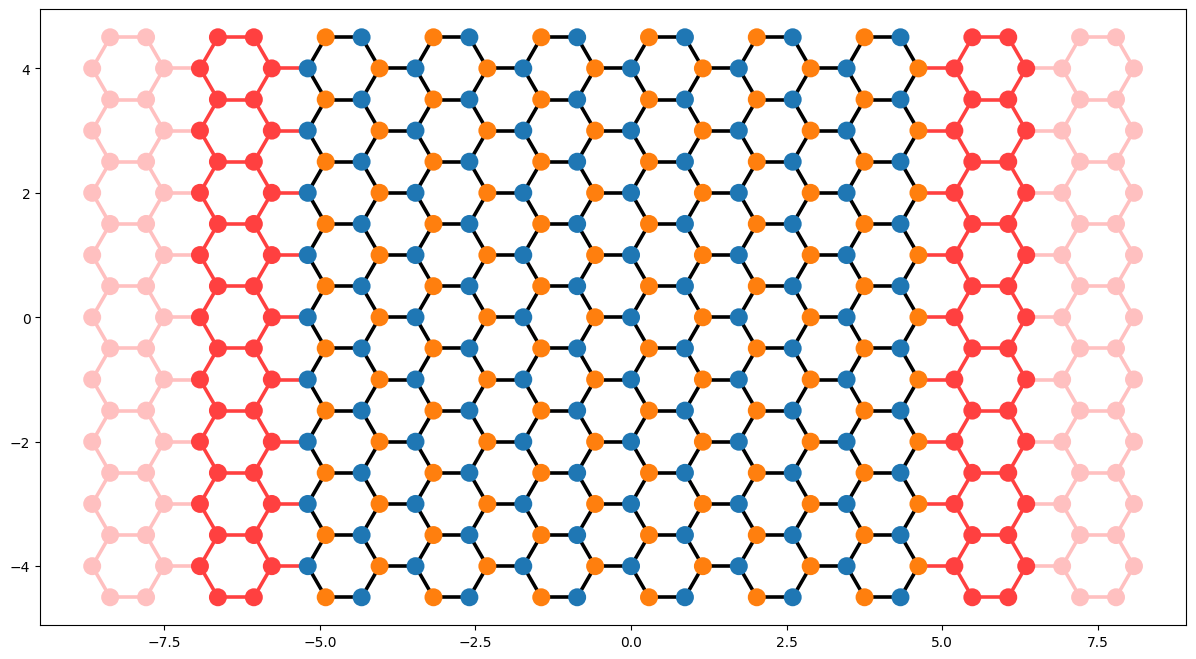

In [40]:
kwant.plot(make_system());

In [44]:
e_fields_array = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.004]
energies_array = np.empty((2001,398,len(e_fields_array)))
dos_array = np.empty((5000,len(e_fields_array)))
entropy_array = np.empty((5000,len(e_fields_array)))

momenta = np.linspace(-np.pi, np.pi, 2001)


In [135]:
dos_array_2 = np.empty((5000,3))
entropy_array_2 = np.empty((5000,3))

In [46]:
%%time   
    
for i, field in enumerate(e_fields_array): 

    bands = kwant.physics.Bands(make_system(E = field, phi = 0.005).leads[0])
    energies_array[:,:,i] = [bands(k) for k in momenta]  
    dos_array[:,i] = [calculate_dos(spectrum=np.concatenate(energies_array[:,:,i]), energy=ei, npoints=npoints, gamma=gamma)
                                   for ei in energyset]    
    entropy_array[:,i] = calculate_entropy(dos_data=dos_array[:,i], npoints_energy=npoints_energy, energy_cut_off=cut_off, mu_set=energyset, T=T)

CPU times: user 28min 25s, sys: 1h 10min 28s, total: 1h 38min 53s
Wall time: 16min 1s


In [ ]:
%%time   

gamma = 0.001
npoints = 10_000
energyset = np.linspace(-4,4,5000)
cut_off = 5.0
npoints_energy = 5000
T = 0.01
    
for i,field in enumerate(e_fields_array[:2]): 

    # bands = kwant.physics.Bands(make_system(E = field, phi = 0.005).leads[0])
    # energies_array[:,:,i] = [bands(k) for k in momenta]  
    dos_array[:,i] = [calculate_dos(spectrum=np.concatenate(energies_array[:,:,i]), energy=ei, npoints=npoints, gamma=gamma)
                                   for ei in energyset]    
    entropy_array[:,i] = calculate_entropy(dos_data=dos_array[:,i], npoints_energy=npoints_energy, energy_cut_off=cut_off, mu_set=energyset, T=T)

In [63]:
#np.savetxt('energies_AGNR', energies_array)
np.savetxt('dos_AGNR', dos_array)
np.savetxt('entropy_AGNR', entropy_array)

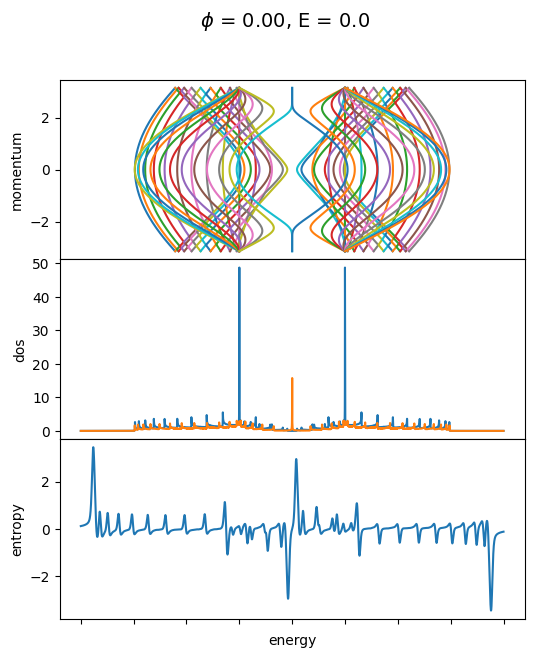

In [37]:
i = 0


fig = plt.figure(figsize=(6, 7))

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

gs.update(hspace=0.0) 
ax0 = plt.subplot(gs[0])
ax0.plot(energies_array[:, :, i], momenta)
ax0.plot(energies_array_zgnr[:, :, i], momenta)
ax0.set_ylabel('momentum')
ax0.set_xticklabels([])

ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.plot(energyset, dos_array[:, i])
ax1.plot(energyset, dos_array_zgnr[:, i])
ax1.set_ylabel('dos')
ax1.set_xticklabels([])

ax2 = plt.subplot(gs[2], sharex=ax1)
ax2.plot(energyset, entropy_array[:, i])
ax2.set_ylabel('entropy')

# Here is where we add the title
plt.suptitle('$\phi$ = 0.00, E = ' + str(e_fields_array[i]) , fontsize=14)

plt.xlabel('energy')
plt.savefig('E=01')
plt.show()


In [129]:
e_fields_array[9]

0.01

In [ ]:
### zoomed picture



fig = plt.figure(figsize=(6, 7))

gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,1])

gs.update(hspace=0.0) 

ax0 = plt.subplot(gs[0])
ax0.plot( energies[2400:2600], momenta[2400:2600])
ax0.set_ylabel('momentum')
ax0.set_xticklabels([])

ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.plot(energyset[2400:2600], dos_wo_fields[2400:2600])
ax1.set_ylabel('dos')
ax1.set_xticklabels([])

ax2 = plt.subplot(gs[2], sharex=ax1)
ax2.plot(energyset[2400:2600], entropy_wo_fields[2400:2600])
ax2.set_ylabel('entropy')

plt.xlabel('energy')
plt.show()

In [58]:
def make_zgnr_system(phi=0.005, E = 0.0):

    size = 100
    
    graphene = kwant.lattice.general([(1, 0), (np.sin(np.pi/6), np.cos(np.pi/6))],
                                     [(0, 0), (0, 1 / np.sqrt(3))],
                                     norbs=1)
    a, b = graphene.sublattices
    
    def rectangle(pos):
        length = size
        x, y = pos
        return - length/2 < x < length/2 and -length/2 < y < length/2+0.3
    
    syst = kwant.Builder()
    
    
    def electric_f(site):
        x, y = site.pos
        return  - E * y

    
    syst[graphene.shape(rectangle, (0, 0))] = electric_f
    
    
    def hopping_magn(site1, site2):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        resphase = - np.exp((-0.5j * phi * (x1 - x2) * (y1 + y2)))
        return resphase
    
    hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
    syst[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping_magn
    
    sym = kwant.TranslationalSymmetry(graphene.vec((-1, 0)))
    
    def lead_shape(pos):
        length = size
        x, y = pos
        return -length/2 < y < length/2+0.3
    
    lead = kwant.Builder(sym)
    lead[graphene.shape(lead_shape, (0, 0))] = electric_f

    
    lead[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = hopping_magn
    
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed());

    
    fsyst = syst.finalized()

    return fsyst

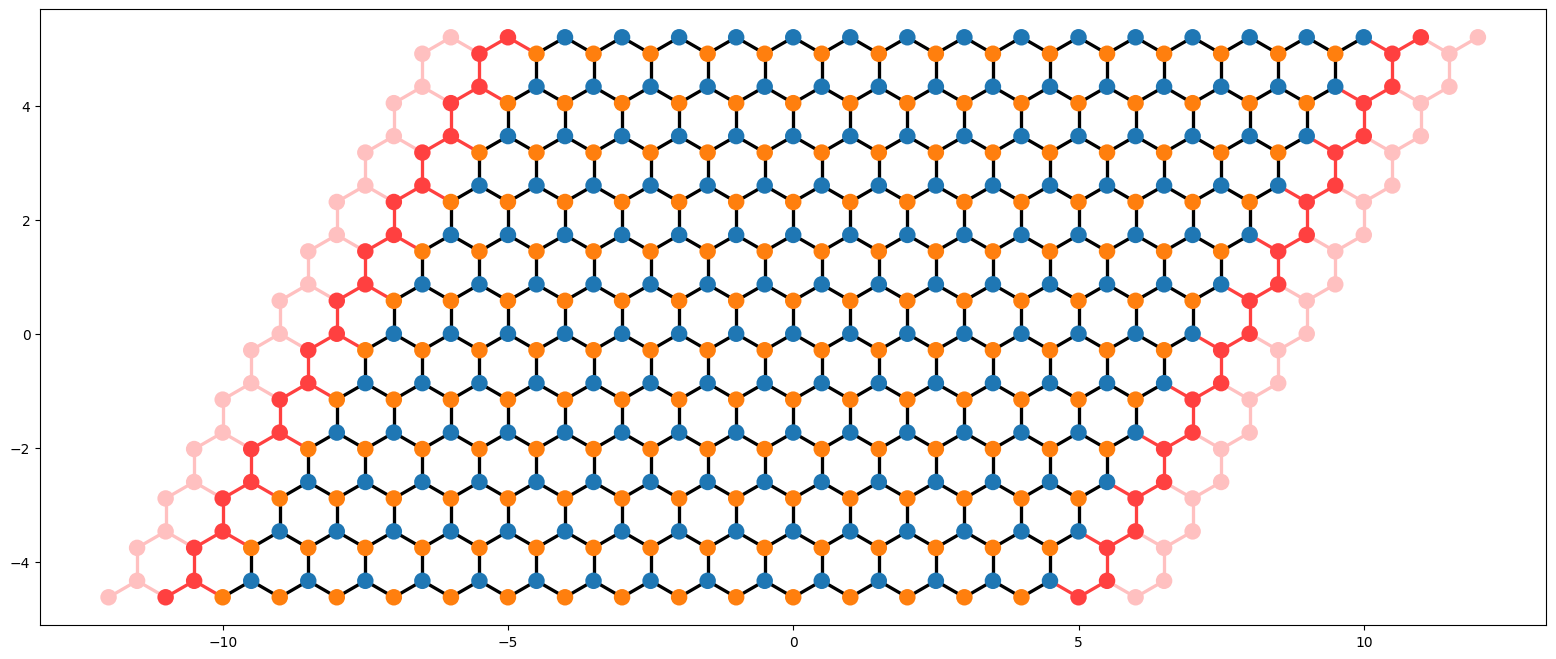

In [17]:
plt.rcParams["figure.figsize"] = (20,8)
kwant.plot(make_zgnr_system());

In [59]:
gamma = 0.001
npoints = 10_000
energyset = np.linspace(-4,4,5000)
cut_off = 5.0
npoints_energy = 5000
T = 0.01

In [60]:
e_fields_array = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.004]
energies_array_zgnr = np.empty((2001,232,len(e_fields_array)))
dos_array_zgnr = np.empty((5000,len(e_fields_array)))
entropy_array_zgnr = np.empty((5000,len(e_fields_array)))

momenta = np.linspace(-np.pi, np.pi, 2001)

In [61]:
%%time   
    
for i, field in enumerate(e_fields_array): 

    bands = kwant.physics.Bands(make_zgnr_system(E = field, phi = 0.00).leads[0])
    energies_array_zgnr[:,:,i] = [bands(k) for k in momenta]  
    dos_array_zgnr[:,i] = [calculate_dos(spectrum=np.concatenate(energies_array_zgnr[:,:,i]), energy=ei, npoints=npoints, gamma=gamma)
                                   for ei in energyset]    
    entropy_array_zgnr[:,i] = calculate_entropy(dos_data=dos_array_zgnr[:,i], npoints_energy=npoints_energy, energy_cut_off=cut_off, mu_set=energyset, T=T)

CPU times: user 9min 25s, sys: 16min 57s, total: 26min 23s
Wall time: 5min 37s


In [62]:
#np.savetxt('energies_ZGNR', energies_array_zgnr)
np.savetxt('dos_ZGNR', dos_array_zgnr)
np.savetxt('entropy_ZGNR', entropy_array_zgnr)

In [22]:
dos_array == dos_array_zgnr[]

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [17]:
energies_array

array([[[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        .